# Quantum Phase Estimation (QPE) for H₂ molecule (noiseless)

Uses PennyLane with harmonized project utilities

In [7]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from notebooks.qpe_utils import plot_qpe_distribution, hartree_fock_energy, signature_hash, run_qpe, save_qpe_result, load_qpe_result
from notebooks.vqe_utils import ensure_dirs, set_seed

# Set random seed and ensure directories exist
set_seed(0)
ensure_dirs()

# Define H₂ molecule
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.7414]])  # bond length in Å
basis = "STO-3G"

# Build molecular Hamiltonian
hamiltonian, num_qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=0, basis=basis
)

# Hartree–Fock reference state
electrons = 2
hf = qchem.hf_state(electrons, num_qubits)

print(f"Molecule: H₂  |  Basis: {basis}")
print(f"Number of qubits: {num_qubits}")
print(f"Hartree-Fock state: {'|' + ''.join(str(bit) for bit in hf) + '⟩'}")


Molecule: H₂  |  Basis: STO-3G
Number of qubits: 4
Hartree-Fock state: |1100⟩


In [8]:
# QPE parameters
molecule_name = "H2"
n_ancilla = 4      # Number of ancilla qubits
t_evol = 1.0       # Evolution time in U = exp(-i * H * t)
trotter_steps = 2  # Trotter order for time evolution
shots = 1000       # Sampling shots

# Noiseless configuration
noise_params = None

# Build unique signature for caching
sig = signature_hash(
    molecule=molecule_name,
    n_ancilla=n_ancilla,
    t=t_evol,
    noise=noise_params,
    shots=shots
)

# Check for cached result
cached = load_qpe_result(molecule_name, sig)

if cached:
    print("✅ Loaded cached QPE result.")
    result = cached
else:
    print("▶️ Running QPE simulation...")
    result = run_qpe(
        hamiltonian=hamiltonian,
        hf_state=hf,
        n_ancilla=n_ancilla,
        t=t_evol,
        trotter_steps=trotter_steps,
        noise_params=noise_params,
        shots=shots,
        molecule_name=molecule_name,
    )
    save_qpe_result(result)

print("\n✅ QPE completed.")
print(f"Most probable bitstring: {result['best_bitstring']}")
print(f"Estimated phase: {result['phase']:.6f}")
print(f"Estimated energy: {result['energy']:.8f} Ha")


✅ Loaded cached QPE result.

✅ QPE completed.
Most probable bitstring: 0100
Estimated phase: 0.125000
Estimated energy: -0.78539816 Ha


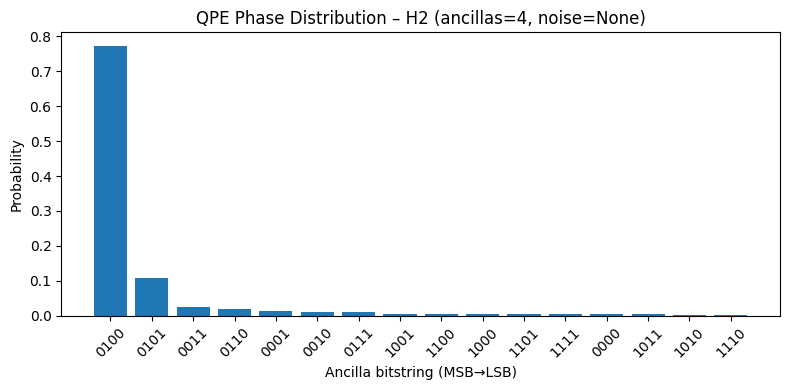

Saved plot → /workspaces/Variational_Quantum_Eigensolver/notebooks/plots/qpe/H2_QPE_4q.png


In [9]:
# Plot QPE distribution
plot_qpe_distribution(result)


In [10]:
# Hartree–Fock Energy Comparison
E_hf = hartree_fock_energy(hamiltonian, hf)

print(f"Hartree–Fock energy: {E_hf:.8f} Ha")
print(f"QPE energy estimate: {result['energy']:.8f} Ha")
print(f"ΔE (QPE - HF): {result['energy'] - E_hf:+.8f} Ha")


Hartree–Fock energy: -0.88842304 Ha
QPE energy estimate: -0.78539816 Ha
ΔE (QPE - HF): +0.10302488 Ha


In [11]:
# Sweep ancillas
anc_list = [3,4,5, 6]
energies, bins = [], []
for n in anc_list:
    r = run_qpe(hamiltonian, hf, n_ancilla=n, t=t_evol, trotter_steps=trotter_steps,
                noise_params=None, shots=2000, molecule_name="H2")
    energies.append(r["energy"])
    bins.append(2*np.pi/(t_evol*(2**n)))

print(list(zip(anc_list, energies, bins)))  # (n_anc, EstE, bin_width)

# Sweep t (keep |E| < π/t, so try t in [0.5, 1.0, 1.5, 2.0])
t_list = [0.5, 1.0, 1.5, 2.0]
energies_t, bins_t = [], []
for tval in t_list:
    r = run_qpe(hamiltonian, hf, n_ancilla=4, t=tval, trotter_steps=trotter_steps,
                noise_params=None, shots=3000, molecule_name="H2")
    energies_t.append(r["energy"])
    bins_t.append(2*np.pi/(tval*(2**4)))
print(list(zip(t_list, energies_t, bins_t)))


[(3, -1.5707963267948966, 0.7853981633974483), (4, -0.7853981633974483, 0.39269908169872414), (5, -1.7671458676442586, 0.19634954084936207), (6, -1.6689710972195777, 0.09817477042468103)]
[(0.5, -1.5707963267948966, 0.7853981633974483), (1.0, -0.7853981633974483, 0.39269908169872414), (1.5, -1.5707963267948966, 0.2617993877991494), (2.0, -1.5707963267948966, 0.19634954084936207)]


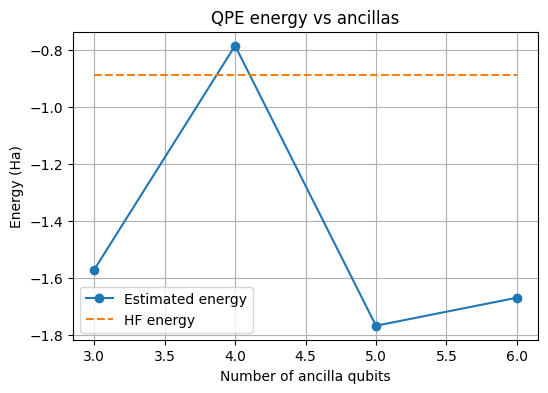

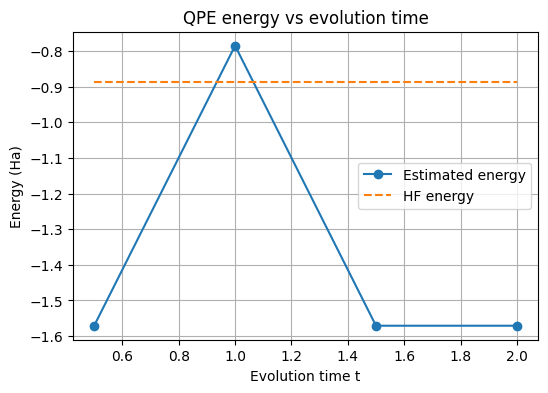

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(anc_list, energies, 'o-', label='Estimated energy')
plt.plot(anc_list, [-0.888423]*len(anc_list), '--', label='HF energy')
plt.xlabel('Number of ancilla qubits')
plt.ylabel('Energy (Ha)')
plt.title('QPE energy vs ancillas')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(t_list, energies_t, 'o-', label='Estimated energy')
plt.plot(t_list, [-0.888423]*len(t_list), '--', label='HF energy')
plt.xlabel('Evolution time t')
plt.ylabel('Energy (Ha)')
plt.title('QPE energy vs evolution time')
plt.legend()
plt.grid(True)
plt.show()
